In [87]:
import random, os, functools, statistics

import numpy as np
import matplotlib.pyplot as plt
import dill, joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import DataLoader

from glio.train2 import *
from glio.visualize import vis_imshow, vis_imshow_grid, Visualizer
from glio.jupyter_tools import show_slices, show_slices_arr, clean_mem
from glio.torch_tools import area_around, one_hot_mask, summary, lr_finder, to_binary, count_parameters
from glio.python_tools import type_str, CacheRepeatIterator
from glio import nn as gnn
from glio.nn import conv, convt, linear, seq
from glio.data import DSToTarget
from glio.helpers import cnn_output_size, tcnn_output_size
from glio.loaders import nifti
from glio.transforms import fToChannels, fToChannelsFirst,fToChannelsLast, z_normalize, norm_to01

from monai.losses.dice import DiceLoss, DiceFocalLoss
from monai.metrics import MeanIoU, SurfaceDiceMetric, DiceHelper # type:ignore
from schedulefree import AdamWScheduleFree

ImportError: cannot import name 'count_parameters' from 'glio.torch_tools' (F:\Stuff\Programming\AI\glio_diff\glio\torch_tools.py)

inp.shape = torch.Size([4, 96, 96]), target.shape = torch.Size([4, 96, 96])
ds.get_preloaded_percent() = 1.0
len(ds) = 120632
len(dstrain) = 108568, len(dstest) = 12064


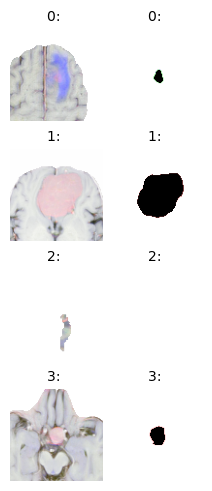

In [2]:
TITLE = "BRATS2024 2D segm"
PRELOAD = 1.

def loader(path:str):
    return torch.tensor(np.stack(list(np.load(path).values())), dtype=torch.float16)[:,-112:112,-112:112]

def tfm_input(data):
    return data[:4].to(torch.float32)

def tfm_target(data):
    return one_hot_mask(data[4], 4)

def plot_preds(learner:Learner, batch, softmax = True, unsqueeze = True):
    batch = list(batch)
    if unsqueeze:
        batch[0] = batch[0].unsqueeze(0)
        batch[1] = batch[1].unsqueeze(0)
    preds = learner.inference(batch[0])
    v = Visualizer()
    v.imshow_grid(batch[0][0], mode="bhw", label="вход")
    v.imshow_grid(batch[1][0], mode="bhw", label = "реальная карта")
    if softmax:
        output = torch.stack([preds[0],preds[0],preds[0]], dim=1)
        output[:,0] *=  F.softmax(preds[0],0)
        v.imshow_grid(output, mode="bchw", label="сырой выход")
        v.imshow_grid(to_binary(F.softmax(preds[0], 0)), mode="bhw", label="предсказанная карта")
    else:
        v.imshow_grid(preds[0], mode="bchw", label="сырой выход")
        v.imshow_grid(to_binary(preds[0], 0), mode="bhw", label="предсказанная карта")
    v.show(figsize=(12, 12))
    
img = loader(r"E:\dataset\BRaTS2024 2D\images\BraTS-GoAT-00000\BraTS-GoAT-00000_21.npz")
inp = tfm_input(img)
target = tfm_target(img)

print(f"{inp.shape = }, {target.shape = }")

# ds = DSToTarget()
# ds.add_folder(r"E:\dataset\BRaTS2024 2D\images", loader, None, tfm_input, tfm_target)
# ds.preload(PRELOAD, True)

ds:DSToTarget = joblib.load(r"F:\Stuff\Programming\experiments\ai\BRaTS2024 preloaded ds.joblib")
print(f"{ds.get_preloaded_percent() = }")
print(f"{len(ds) = }")
dstrain, dstest = ds.split(0.9)
print(f"{len(dstrain) = }, {len(dstest) = }")
dstrain.preview()

In [60]:
from monai.networks.nets import SegResNetDS # type:ignore

summary(SegResNetDS(2, in_channels=4, out_channels=4, init_filters=16), (8, 4, 96,96))

path                                         module                                       input size               output size              params    buffers   
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/conv_inittorch.nn.modules.conv.Conv2d                 (8, 4, 96, 96)           (8, 16, 96, 96)          576       0         
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/layers/0/blocks/0/norm1torch.nn.modules.batchnorm.BatchNorm2d       (8, 16, 96, 96)          (8, 16, 96, 96)          32        33        
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/layers/0/blocks/0/act1torch.nn.modules.activation.ReLU             (8, 16, 96, 96)          (8, 16, 96, 96)          0         0         
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/layers/0/blocks/0/conv1torch.nn.modules.conv.Conv2d                 (8, 16, 96, 96)          (8, 16, 96, 96)          2304      0         
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/layers/0/blocks/0/norm2torch.nn.m

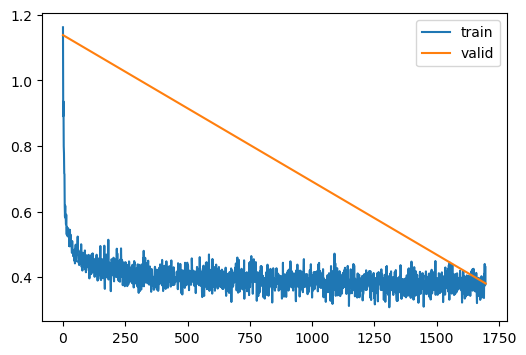

Training took 688.0047489000717 seconds. Results:
 - last train loss: learner.logger.last("train loss") = 0.3788284361362457
 - best train loss: learner.logger.min("train loss") = 0.30834031105041504

 - last test loss: learner.logger.last("test loss") = 0.3808321780943997
 - best test loss: learner.logger.min("test loss") = 0.3808321780943997



ValueError: No data found for output histogram

In [78]:
MODEL = SegResNetDS(2, in_channels=4, out_channels=4, init_filters=24)
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-2
BATCH_SIZE = 64
N_EPOCHS = 1

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = AdamWScheduleFree(MODEL.parameters())
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = None

clean_mem()
#model = gnn.LSUV(model, dl_train)

LEARNER_NAME = f"{NAME} lr={LR} bs={BATCH_SIZE} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16), 
                         Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), Accelerate("no"), 
                         Metric_PredsTargetsFn(DiceLoss(softmax=True), step=4),
                         FastProgressBar(plot=True, step_batch=16, metrics=["train loss", "test loss", "train fn - DiceLoss", "test fn - DiceLoss"]),
                         ),
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train loss: {learner.logger.last("train loss") = }')
print(f' - best train loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test loss: {learner.logger.last("test loss") = }')
print(f' - best test loss: {learner.logger.min("test loss") = }')
print()

plt.show()
learner.logger.hist_all("output histogram")
plt.show()
learner.logger.hist_all("grad histogram")
plt.show()
plot_preds(learner, next(iter(dltrain)))

torch.Size([64, 4, 96, 96])
torch.Size([4, 3, 96, 96])


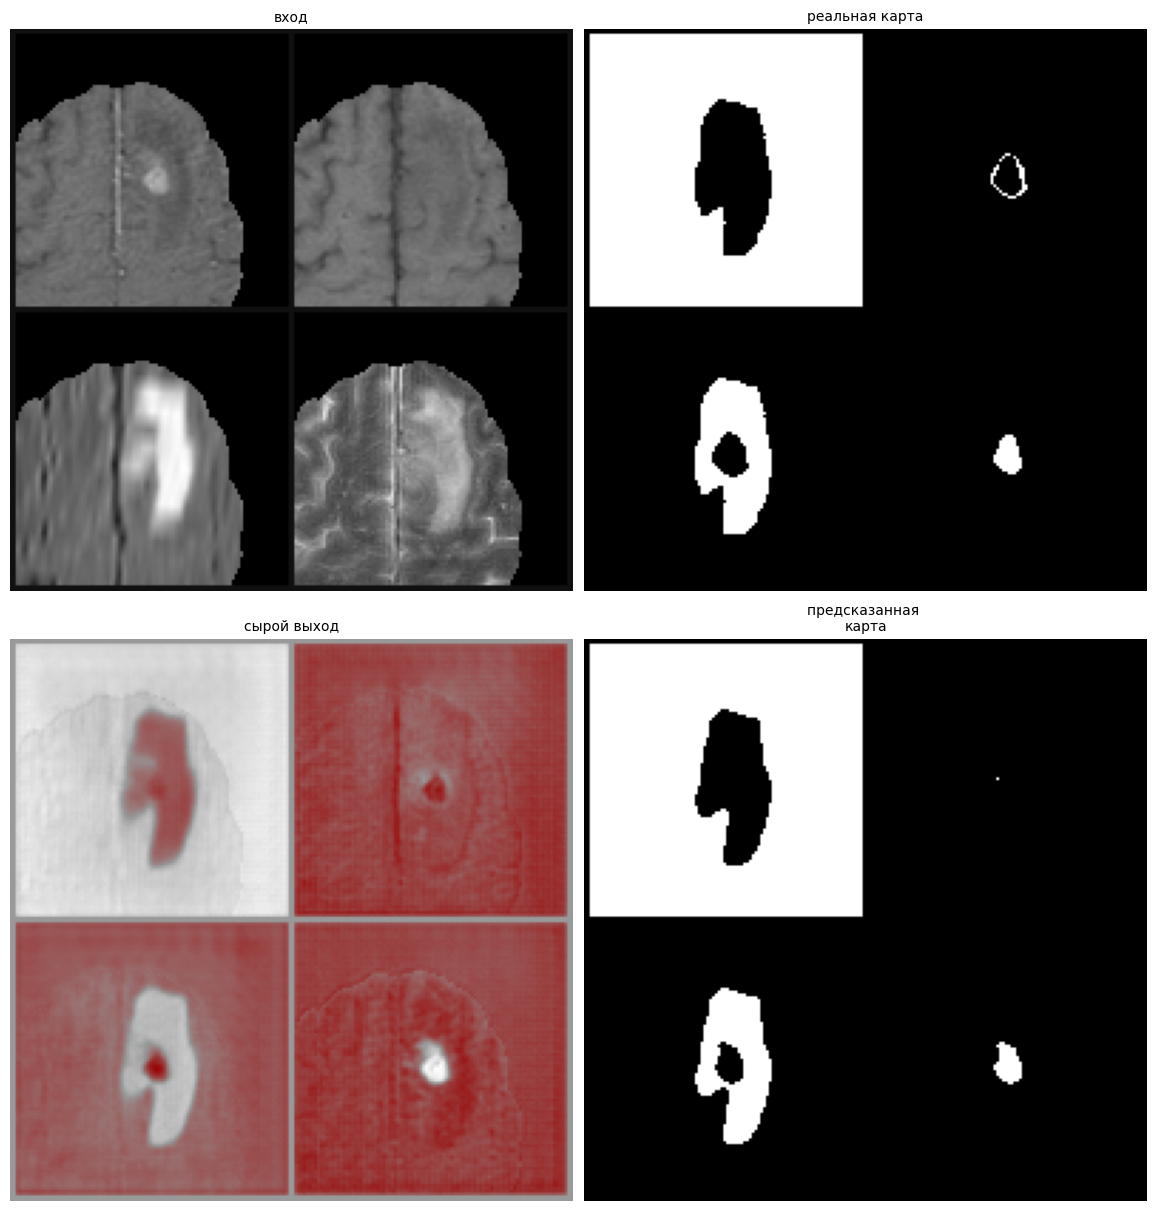

In [79]:
plot_preds(learner, next(iter(dltrain)))

torch.Size([1, 4, 96, 96])
torch.Size([4, 3, 96, 96])


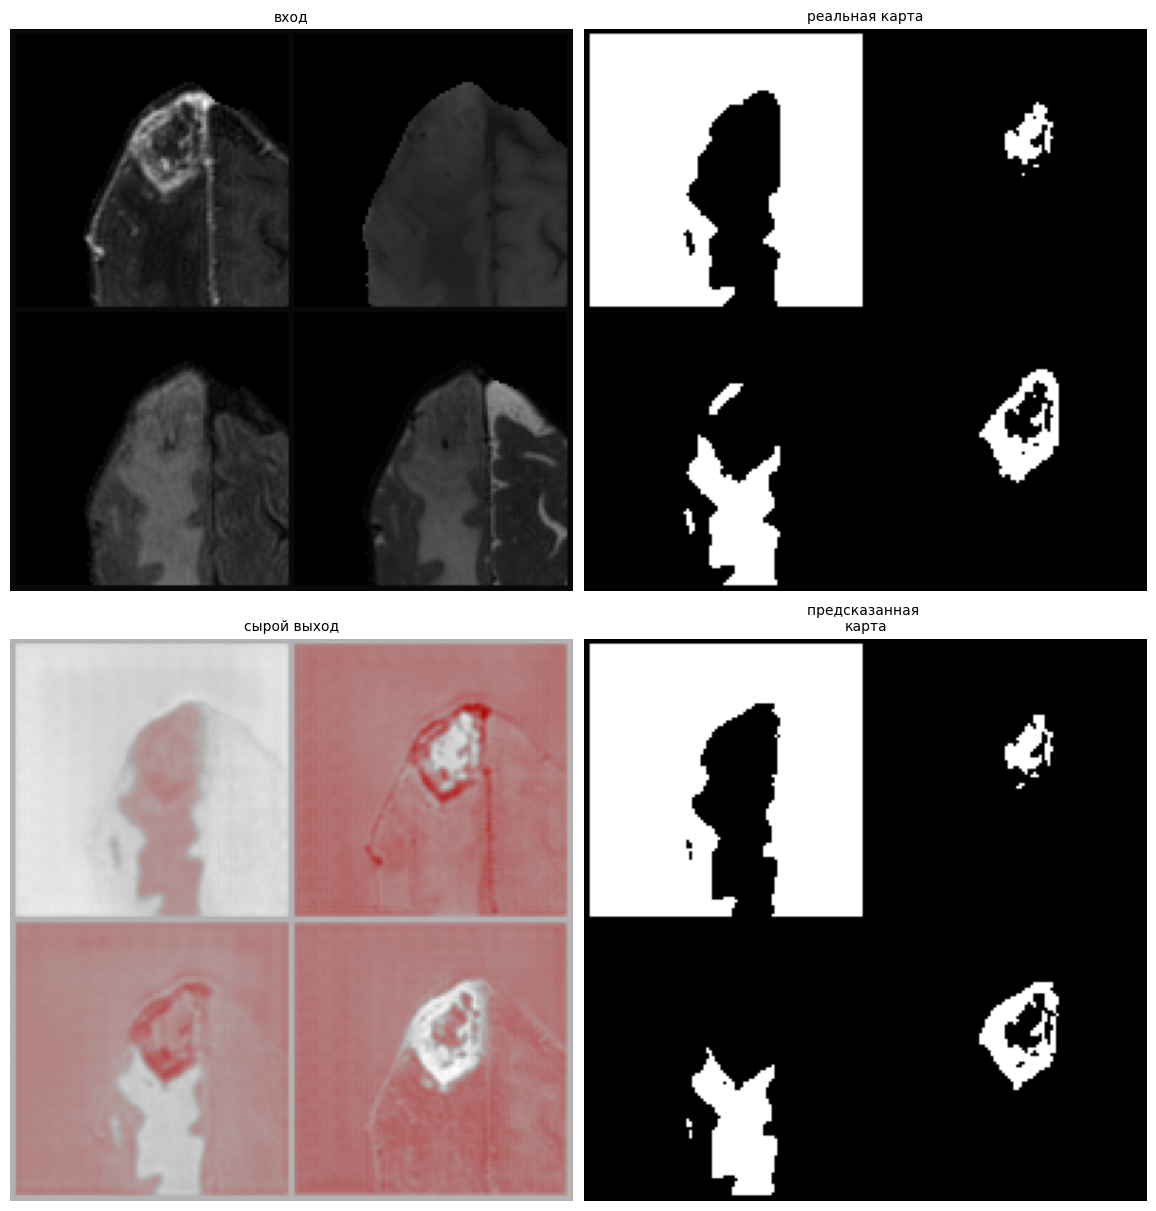

In [80]:
plot_preds(learner, dstrain[4], unsqueeze=True)

In [81]:
learner.logger.keys()

dict_keys(['test loss', 'test fn - monai.losses.dice.DiceLoss', 'time', 'lr', 'train loss', 'train fn - monai.losses.dice.DiceLoss'])

In [84]:
from monai.networks.nets import HighResNet # type:ignore

summary(HighResNet(2, 4, 4), (8, 4, 96,96))

path                                         module                                       input size               output size              params    buffers   
monai.networks.nets.highresnet.HighResNet/blocks/0/convtorch.nn.modules.conv.Conv2d                 (8, 4, 96, 96)           (8, 16, 96, 96)          576       0         
monai.networks.nets.highresnet.HighResNet/blocks/0/adn/Ntorch.nn.modules.batchnorm.BatchNorm2d       (8, 16, 96, 96)          (8, 16, 96, 96)          32        33        
monai.networks.nets.highresnet.HighResNet/blocks/0/adn/Atorch.nn.modules.activation.ReLU             (8, 16, 96, 96)          (8, 16, 96, 96)          0         0         
monai.networks.nets.highresnet.HighResNet/blocks/1/layers/0/Ntorch.nn.modules.batchnorm.BatchNorm2d       (8, 16, 96, 96)          (8, 16, 96, 96)          32        33        
monai.networks.nets.highresnet.HighResNet/blocks/1/layers/0/Atorch.nn.modules.activation.ReLU             (8, 16, 96, 96)          (8, 16, 96, 96) 

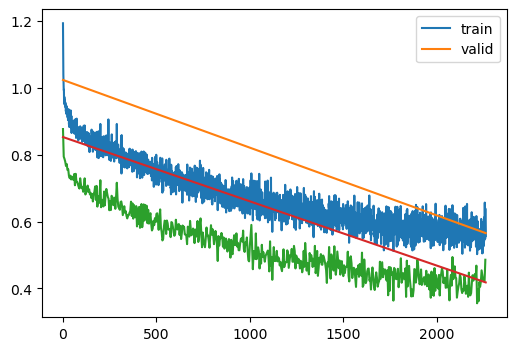

Training took 1833.425920199952 seconds. Results:
 - last train loss: learner.logger.last("train loss") = 0.5563309788703918
 - best train loss: learner.logger.min("train loss") = 0.502350926399231

 - last test loss: learner.logger.last("test loss") = 0.5653018376656941
 - best test loss: learner.logger.min("test loss") = 0.5653018376656941

 - last train dice: learner.logger.last("train fn - monai.losses.dice.DiceLoss") = 0.4856511354446411
 - best train dice: learner.logger.min("train fn - monai.losses.dice.DiceLoss") = 0.3554033637046814

 - last test dice: learner.logger.last("test fn - monai.losses.dice.DiceLoss") = 0.41782008135129534
 - best test dice: learner.logger.min("test fn - monai.losses.dice.DiceLoss") = 0.41782008135129534

torch.Size([48, 4, 96, 96])
torch.Size([4, 3, 96, 96])


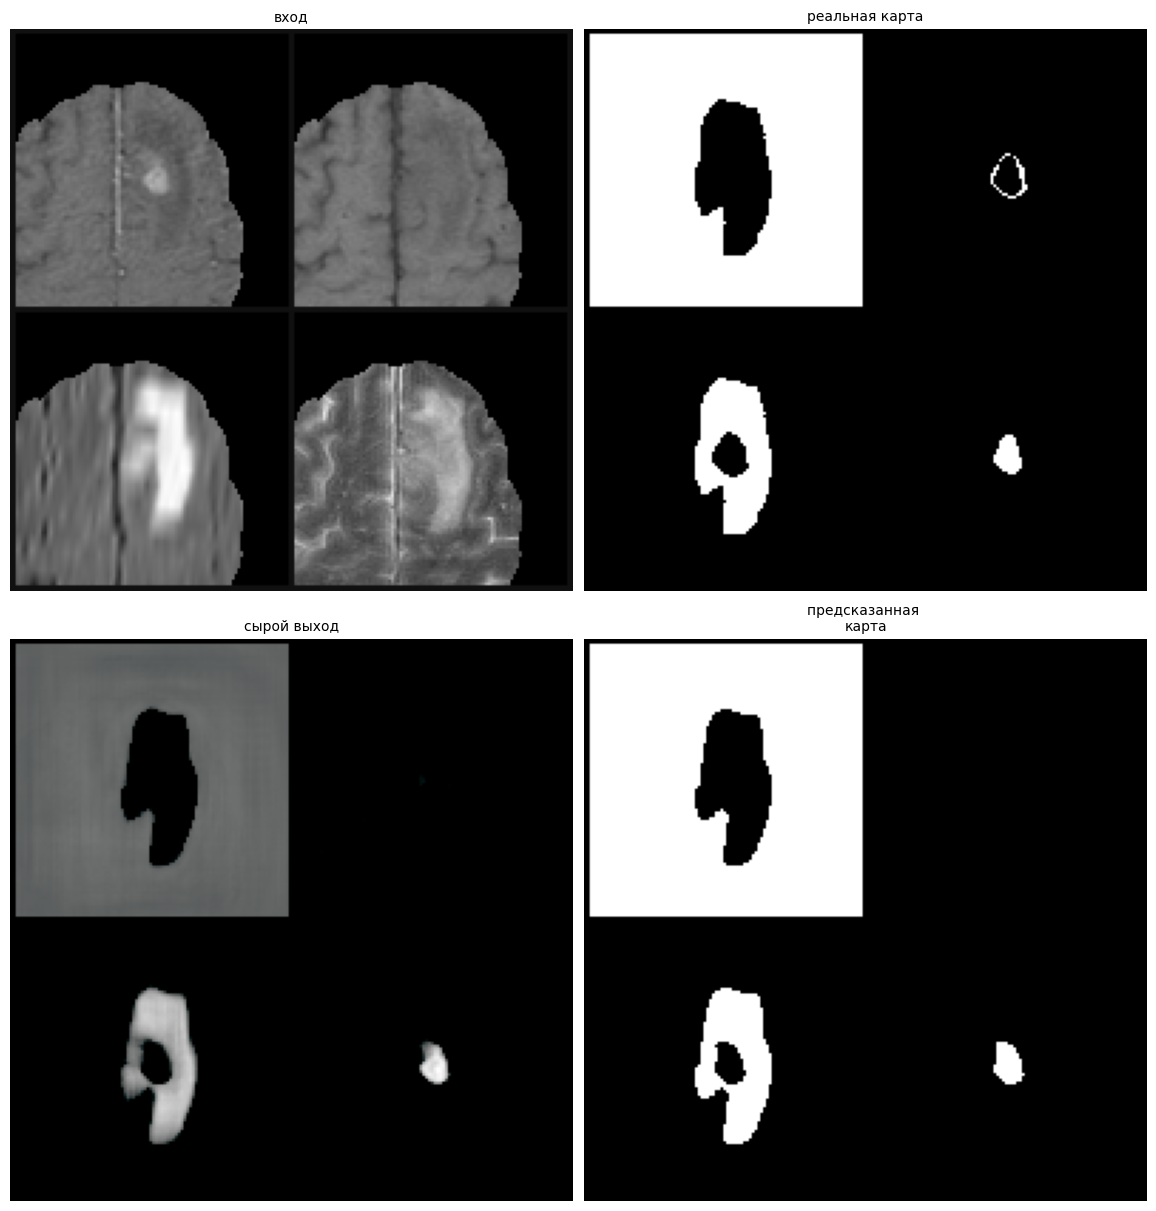

In [86]:
MODEL = HighResNet(2, 4, 4)
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-2
BATCH_SIZE = 48
N_EPOCHS = 1

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = AdamWScheduleFree(MODEL.parameters())
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = None

clean_mem()
#model = gnn.LSUV(model, dl_train)

LEARNER_NAME = f"{NAME} lr={LR} bs={BATCH_SIZE} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16), 
                         Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), Accelerate("no"), 
                         Metric_PredsTargetsFn(DiceLoss(softmax=True), step=4),
                         FastProgressBar(plot=True, step_batch=16, metrics=["train loss", "test loss", "train fn - monai.losses.dice.DiceLoss", "test fn - monai.losses.dice.DiceLoss"]),
                         ),
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train loss: {learner.logger.last("train loss") = }')
print(f' - best train loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test loss: {learner.logger.last("test loss") = }')
print(f' - best test loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train dice: {learner.logger.last("train fn - monai.losses.dice.DiceLoss") = }')
print(f' - best train dice: {learner.logger.min("train fn - monai.losses.dice.DiceLoss") = }')
print()
print(f' - last test dice: {learner.logger.last("test fn - monai.losses.dice.DiceLoss") = }')
print(f' - best test dice: {learner.logger.min("test fn - monai.losses.dice.DiceLoss") = }')
print()


plt.show()
plot_preds(learner, next(iter(dltrain)))

torch.Size([1, 4, 96, 96])
torch.Size([4, 3, 96, 96])


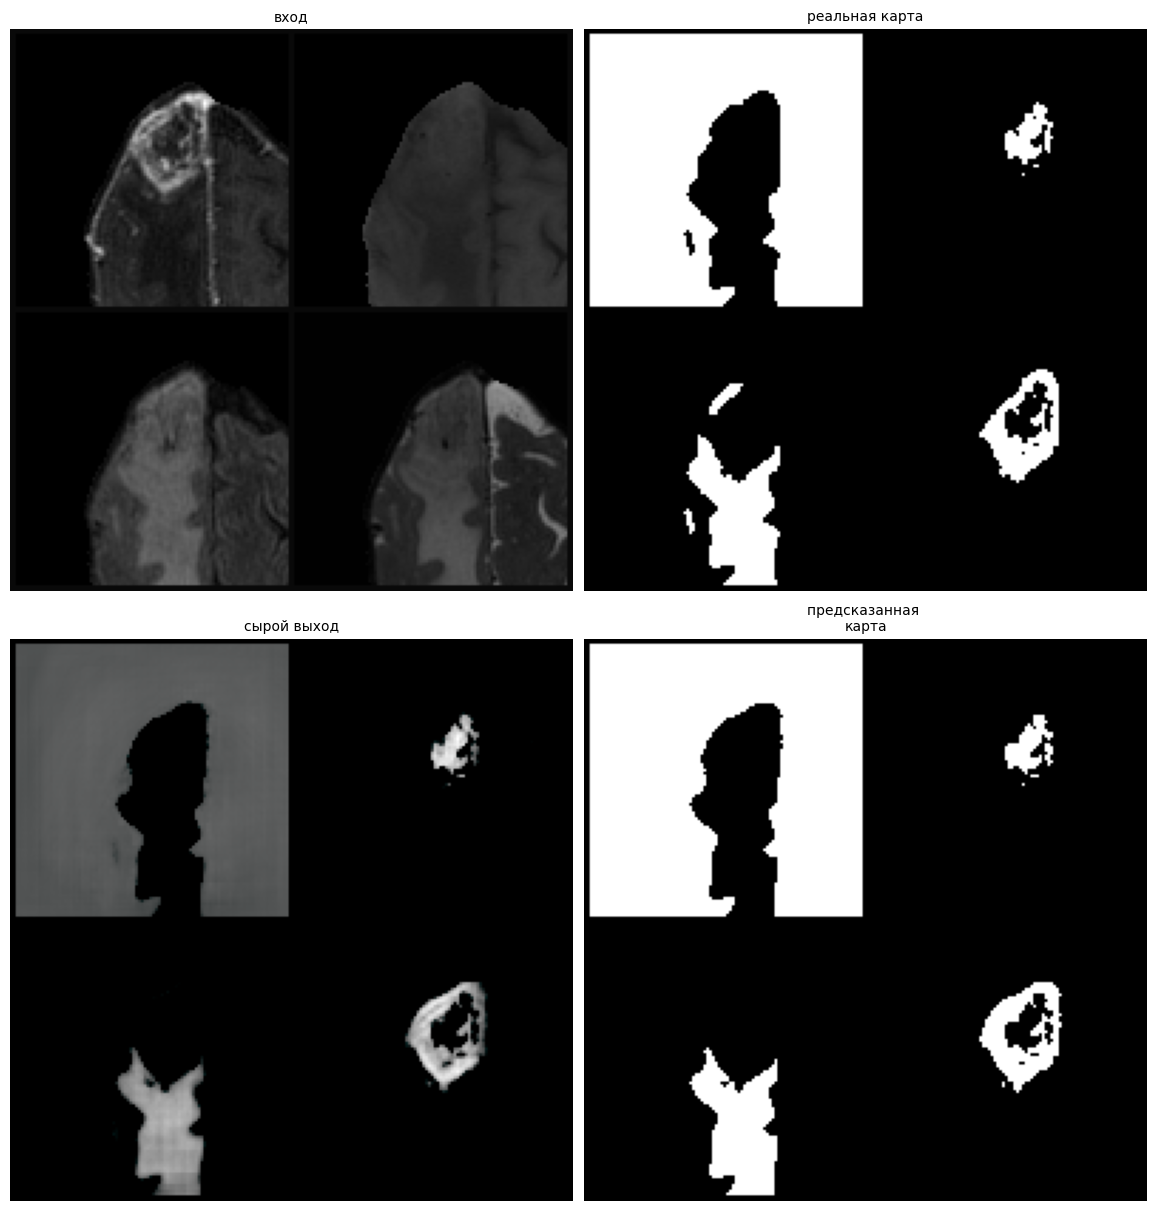

In [88]:
plot_preds(learner, dstrain[4], unsqueeze=True)

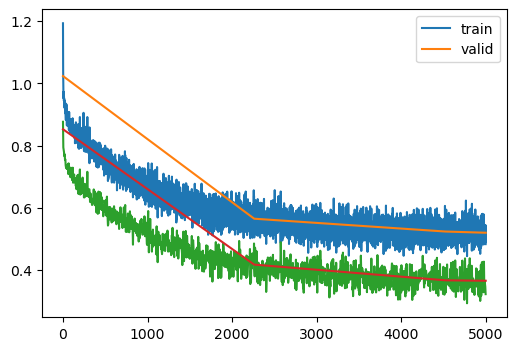

Keyboard interrupt, testing one last time... Press stop again to cancel.
Training took 4038.177404099959 seconds. Results:
 - last train loss: learner.logger.last("train loss") = 0.4836122691631317
 - best train loss: learner.logger.min("train loss") = 0.44505298137664795

 - last test loss: learner.logger.last("test loss") = 0.5202263334677333
 - best test loss: learner.logger.min("test loss") = 0.5202263334677333

 - last train dice: learner.logger.last("train fn - monai.losses.dice.DiceLoss") = 0.32298606634140015
 - best train dice: learner.logger.min("train fn - monai.losses.dice.DiceLoss") = 0.29361867904663086

 - last test dice: learner.logger.last("test fn - monai.losses.dice.DiceLoss") = 0.36605054423922584
 - best test dice: learner.logger.min("test fn - monai.losses.dice.DiceLoss") = 0.36605054423922584



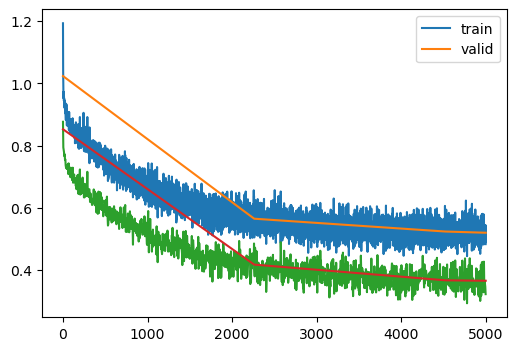

torch.Size([48, 4, 96, 96])
torch.Size([4, 3, 96, 96])


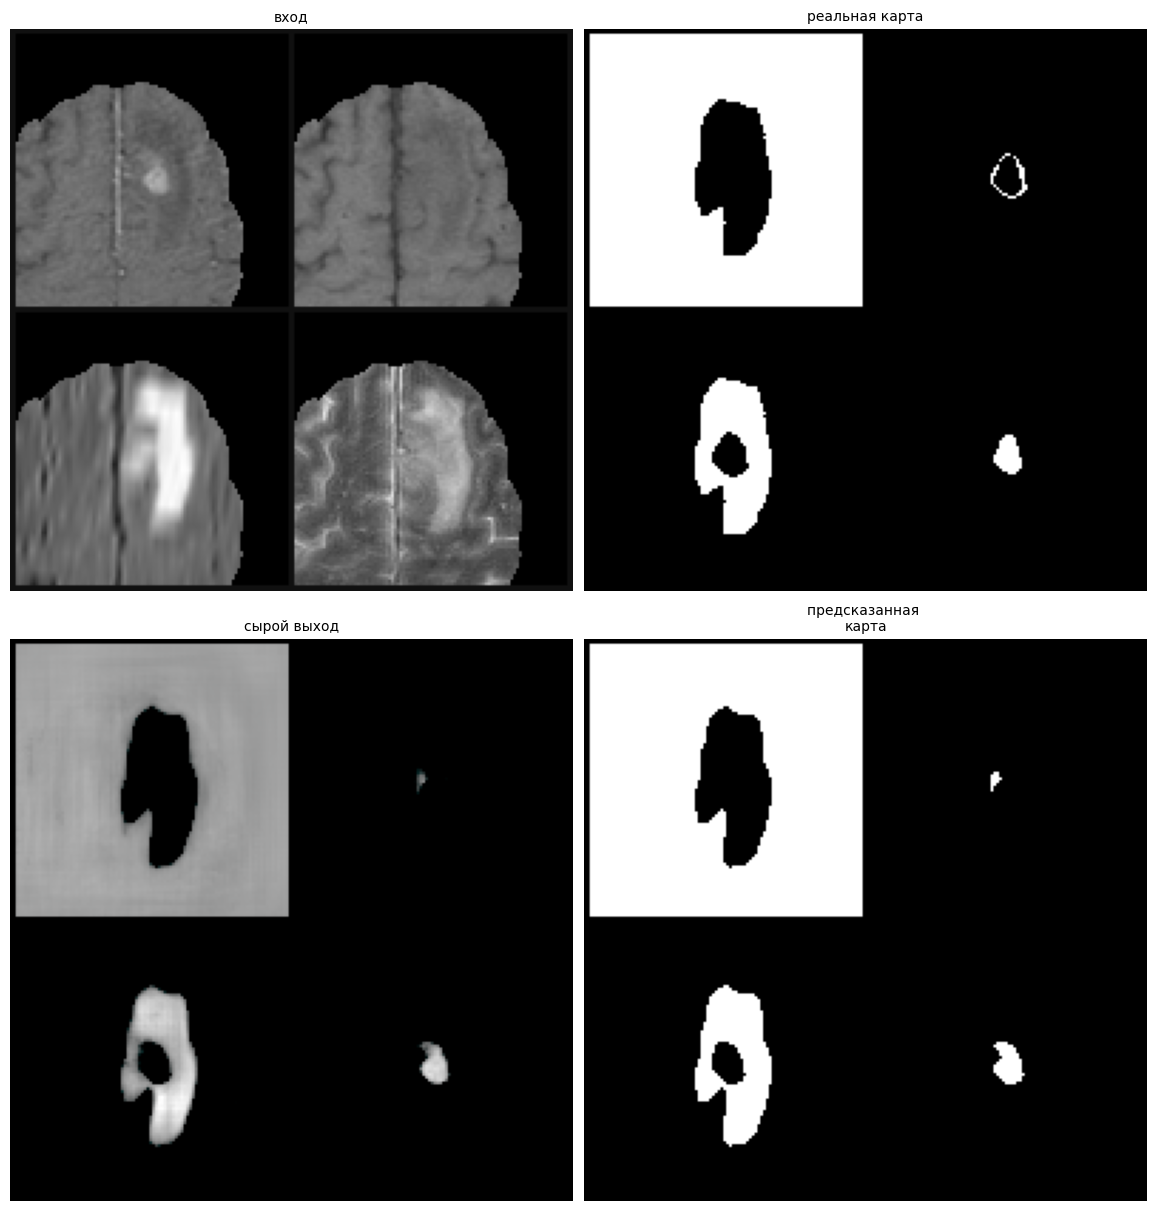

torch.Size([1, 4, 96, 96])
torch.Size([4, 3, 96, 96])


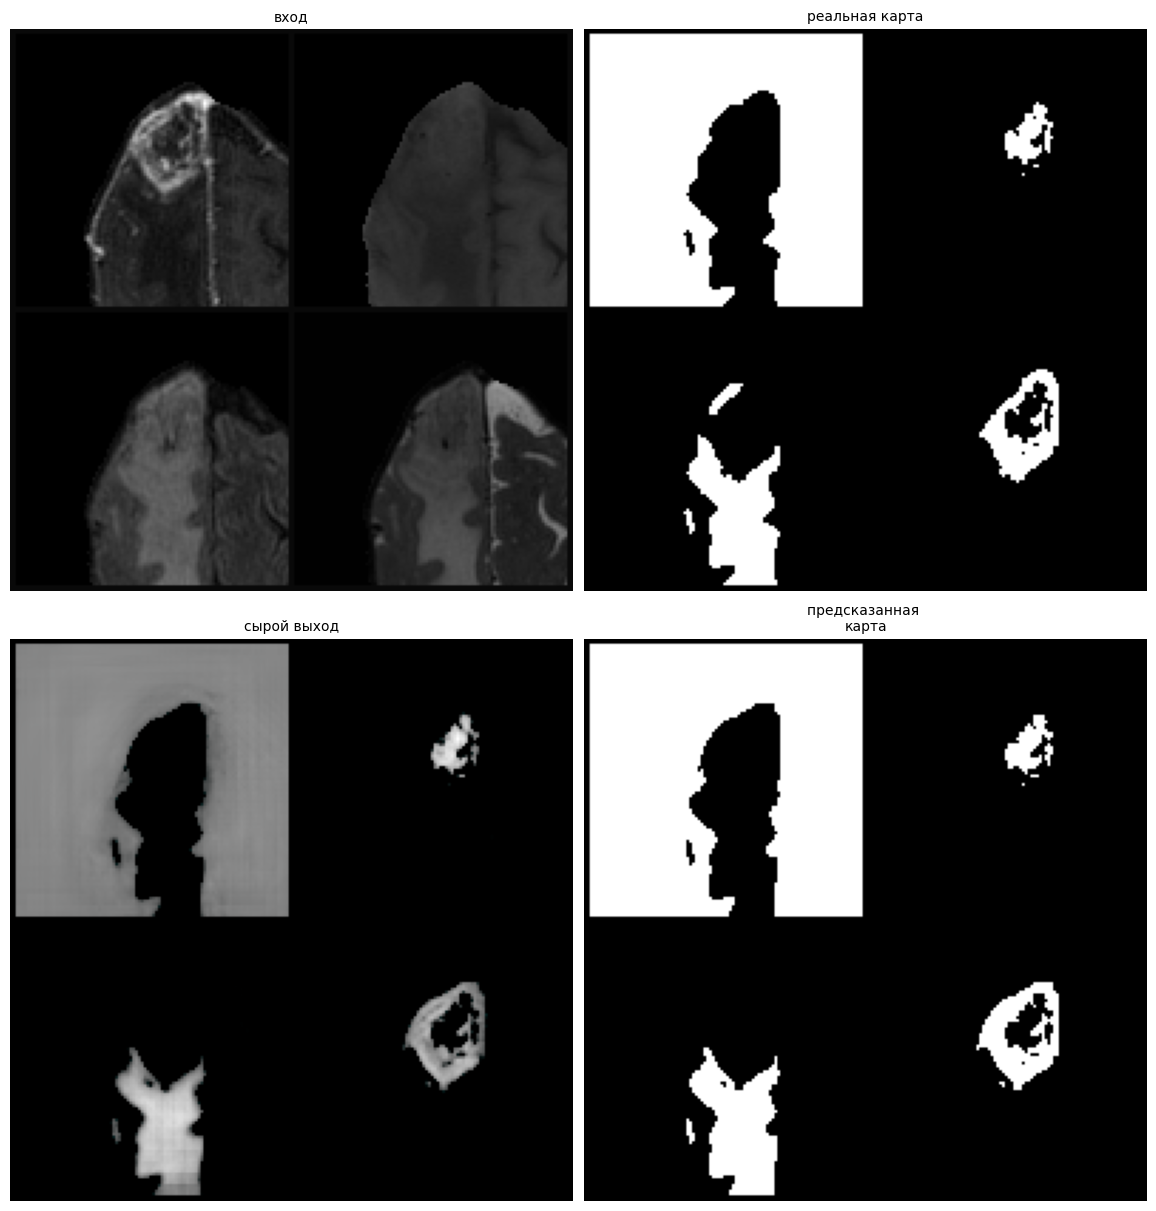

In [89]:
learner.fit(3, dltrain, dltest)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train loss: {learner.logger.last("train loss") = }')
print(f' - best train loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test loss: {learner.logger.last("test loss") = }')
print(f' - best test loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train dice: {learner.logger.last("train fn - monai.losses.dice.DiceLoss") = }')
print(f' - best train dice: {learner.logger.min("train fn - monai.losses.dice.DiceLoss") = }')
print()
print(f' - last test dice: {learner.logger.last("test fn - monai.losses.dice.DiceLoss") = }')
print(f' - best test dice: {learner.logger.min("test fn - monai.losses.dice.DiceLoss") = }')
print()


plt.show()
plot_preds(learner, next(iter(dltrain)))
plot_preds(learner, dstrain[4], unsqueeze=True)